Simulation Code for Apendix B of "Epistemology and Anomaly Dection in Astrobiology"
-------------

The code below implements the simulation described in Appendix B of "Episemology and Anomaly Detection in Astrobiology". It takes approximately 70 minutes to run the simulation on a 2020 MacBook Pro. 

In [ ]:
#Import the necessary packages.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [179]:
#Define empty arrays for x and y values.
x_vals = []
y_vals = []

#Use a for-loop to iterate the simulation ten times for each value of x.
for q in tqdm.tqdm(np.arange(0,10)):
    
#Use a for-loop to iterate the simulation for each value of x.
    for x in np.arange(1,10.2,.2):
        #Randomly sample from a Dirichlet distribution to generate the group of abundance vectors W_A.
        group_A_param = [10 for i in range(0,100)]
        group_A_param = np.append(group_A_param,[1 for i in range(0,900)])
        group_A = np.random.dirichlet(group_A_param,(90,1))
        
        #Randomly sample from a Dirichlet distribution to generate the group of abundance vectors W_B.

        group_B_param = [x for i in range(0,100)]
        group_B_param = np.append(group_B_param,[1 for i in range(0,900)])
        group_B = np.random.dirichlet(group_B_param,(10,1))
        
        #Combine the groups into a single array.

        combined_groups = np.vstack((group_A, group_B))
        
        #Generate a matrix containing the Euclidean distance between each pair of abundance vectors in the full data set W.

        distance_matrix=np.zeros((100,100))
        for i in range(0,100):
            distance_matrix[i] = [np.linalg.norm(combined_groups[i] - combined_groups[j]) for j in range(0,100)]
            
        #Find the minimum and average distance between any vector in W and its nearest neighbor, in order to calculate the shape paraemter sigma form W.

        nearest_neighbor_distances = np.zeros(100)
        for i in range(0,100):
            nearest_neighbor_distances[i] = min(j for j in distance_matrix[i] if j>0)

        min_distance = np.min(nearest_neighbor_distances)
        avg_distance = np.mean(nearest_neighbor_distances)

        sigma = -np.log(min_distance/avg_distance)/(avg_distance**2 - min_distance**2)
        
        #Computer the value of the weight parameter alpha for W. In principle, we would use constrained optimization to compute alpha, and code for doing 
        #so is included below, though commented out. In practice, alpha is always the uniform vector or something very close to uniform, and so for the sake of efficiency
        #I have set alpha to the uniform vector below. 

        alpha = [1/100]*100

        # def objective(alpha):
        #     terms = np.array([np.array([alpha[j]*alpha[k]*np.exp(-(distance_matrix[j,k]**2)/sigma**2) for k in range(0,100)]) for j in range(0,100)])
        #     summands = []
        #     for j in range(0,100):
        #         for k in range(0,100):
        #             if j==k:
        #                 summands = np.append(summands,[0])
        #             if j!=k:
        #                 summands = np.append(summands,[terms[j,k]])
        #     return np.sum(summands)

        # alpha0=np.zeros(100)

        # def constraint(alpha):
        #     return np.sum(alpha)-1

        # b = (0,1)
        # bnds = [b for i in range(0,100)]
        # con1 = {'type': 'eq', 'fun': constraint}
        # cons = [con1]

        # solution = minimize(objective,alpha0,method='SLSQP',bounds=bnds,constraints=cons)
        # alpha = solution.x
        
        
        #Define the anomalousness function. 

        def anomalousness(i):
            summands1 = []
            for j in range(0,100):
                    if j==i:
                        summands1 = np.append(summands1,[0])
                    if j!=i:
                        summands1 = np.append(summands1,[alpha[j]*np.exp(-(distance_matrix[i,j]**2)/sigma**2)])
            sum1 = np.sum(summands1)
            summands2 = []
            for j in range(0,100):
                for k in range(0,100):
                    if j==i:
                        summands2 = np.append(summands2,[0])
                    if k==i:
                        summands2 = np.append(summands2,[0])
                    else:
                        summands2 = np.append(summands2,[alpha[j]*alpha[k]*np.exp(-(distance_matrix[j,k]**2)/sigma**2)])
            sum2 = np.sum(summands2)
            return 1 - 2*sum1 + sum2
        
        #Calculate anomalousness for each element of W.

        anomalousness_measures = [anomalousness(i) for i in range(0,100)]
        
        #Identify the top ten most anomalous abundance vectors in W, and calculate the proportion that are elements of W_B.
        
        top_ten = np.argpartition(anomalousness_measures, -10)[-10:]
        y = 0
        for i in range(0,10):
            if top_ten[i]>=90:
                y=y+1
            else:
                y=y
                
        #Save the value of x and the proportion of top-ten anomalous vectors that are also elements of W_B.
                
        x_vals = np.append(x_vals,[x])
        y_vals = np.append(y_vals,[y/10])

100%|██████████| 10/10 [1:18:09<00:00, 468.92s/it]


In [194]:
#Post-simulation, save the set of x and y values obtained as .txt files.
np.savetxt('xvals.txt',x_vals)
np.savetxt('yvals.txt',y_vals)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


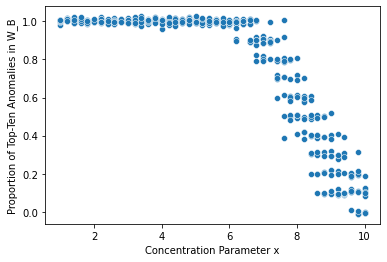

In [228]:
#Generate a scatterplot showing the relationship between x and y in your simulation. 
df = pd.DataFrame({'xvalues': x_vals, 'yvalues': y_vals + .01*np.random.randn(460)})
sns.scatterplot('xvalues', 'yvalues', data=df)
plt.xlabel('Concentration Parameter x')
plt.ylabel('Proportion of Top-Ten Anomalies in W_B')
plt.savefig('sim_plot.png')